In [105]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.stats import norm
from scipy.integrate import odeint

M = 20 #число мод
N = 1000 #число генераций выборки
dk = math.pi / (M + 1.)
timeMax = 1000
timeSteps = 10 * timeMax
time = np.linspace(0, timeMax, timeSteps)


epsilon0 = 1.
epsilon = epsilon0
h = 0.42 #Должно быть 0.05?


sigmaZ = np.array([1, 0, 0, -1]).reshape(2, 2)
sigmaPlus = np.array([0, 1, 0, 0]).reshape(2, 2)
sigmaMinus = np.array([0, 0, 1, 0]).reshape(2, 2)

#Изначально спин направлен вверх
psi0 = np.array([1., 0.])

def f(t):
    return .1*np.cos(t)

def zFunction(omega, z, c, t):
    return np.dot (c, np.exp(1.j * omega * t) * z.conjugate())

def HSys(t):
    return epsilon * sigmaZ + sigmaPlus * f(t) + sigmaMinus * f(t).conjugate()

def H(omega, z, c, t):
    return HSys(t) + sigmaMinus * zFunction(omega, z, c, t)

def getShredingerEq(omega, z, c):
    def ShredingerEq(psi, t):
        #[:,np.newaxis]).flatten().tolist() #Если вдруг что, проверить psi
        return -1.j * np.dot(H(omega, z, c, t), psi)
    return ShredingerEq

In [106]:
#параметры модели
omega = epsilon + 2. * h * np.cos(dk*np.arange(1, M + 1))
c = np.sqrt(2. / np.pi * dk) * h * np.sin(dk*np.arange(1, M + 1))

In [107]:
#вспомагательная функция для odeint(рабоатет только с действит.значными ф-ми)
def getShredingerEqWrapper(ShredingerEq):
    def ShredingerEqWrapper(y, t):
        res = ShredingerEq([y[0] + 1.j*y[1], y[2] + 1.j*y[3]], t)
        return [res[0].real, res[0].imag, res[1].real, res[1].imag]
    return ShredingerEqWrapper

#Нормированная квадратичная форма (оператор в обкладках из состояний)
nqm = lambda A, x :\
    (np.dot(x.T.conjugate() ,np.dot(A, x))) / np.dot (x.T.conjugate(), x)

In [108]:
psiTotal = np.zeros(shape = (N, timeSteps, 4), dtype = float)

for i in np.arange(N):
    #генерируем вектор z: z_i = (x + j*y)/sqrt(2); x, y из N(0, 1) 
    z = (np.random.normal(size=M) + 1.j * np.random.normal(size=M)) / np.sqrt(2)

    ShredingerEq = getShredingerEq(omega, z, c)
    ShredingerEqWrapper = getShredingerEqWrapper(ShredingerEq)
    psiWrapper = np.array([psi0[0].real, psi0[0].imag, 
                          psi0[1].real, psi0[1].imag])
    
    psiTotal[i] = odeint(ShredingerEqWrapper, psiWrapper, time)

In [109]:
psiUp = (psiTotal[:, :, 0] + 1.j*psiTotal[:, :, 1])
psiDown = (psiTotal[:, :, 2] + 1.j*psiTotal[:, :, 3])
psi = np.concatenate((psiUp[:,:,np.newaxis], psiDown[:,:,np.newaxis]), axis = 2)

sigmaZAverage = np.zeros(timeSteps, dtype = np.complex)

for i in np.arange(N):
    for k in np.arange(timeSteps):
        sigmaZAverage[k] += nqm(sigmaZ, psi[i, k])

sigmaZAverage /= N

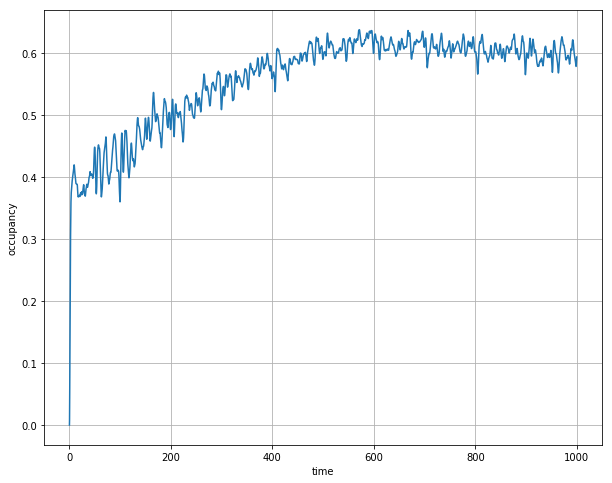

In [110]:
# Отрисовка
fig = plt.figure(figsize=(10,8))
pl = fig.add_subplot(111)
pl.set_xlabel("time")
pl.set_ylabel("occupancy")
pl.grid(1)
pl.grid(True)

#sigmaZAverage - среднее значение спина (диапазон от -1 до 1). 
#.5 *(1 - sigmaZAverage) - заполнение уровня (от 0 до 1). Равновесие 0.5
pl.plot(time, .5 *(1 - sigmaZAverage))

plt.show()